## Right angle crash data visualization and analysis.


### Import python modules and libraries.

In [6]:
import os
import arcpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from python.sparkInit import spark_start, spark_stop
from pyspark.sql.functions import pandas_udf, hour,cos, sin, radians,col
from pyspark.sql.types import DoubleType
from scipy import stats
%matplotlib inline

In [7]:
# data path and work space that needs to be processed
prjPath=r'C:\projects\ESRICrash\CrashAnalysisDOT\CobbCrashAnalysis\CobbCrashAnalysis.gdb'
prjCrash=os.path.join(prjPath,'Crash_new') #can also prjPath+'\\Crash_new'
intersection =os.path.join(prjPath,'intersections')
arcpy.env.workspace=prjPath
arcpy.env.overwriteOutput=True

### Start a Spark instance.

Note the `config` argument to [configure the Spark instance](https://spark.apache.org/docs/latest/configuration.html).

In [8]:
config = {"spark.driver.memory":"2G"}
spark = spark_start(config=config)

In [9]:
#check field names in Feature class
print ([f.name for f in arcpy.ListFields(prjCrash)])

['OBJECTID', 'Shape', 'ACCIDENTDATE', 'REPORTEDDATE', 'REPORTEDBY', 'UPDATED', 'UPDATEDBY', 'VEHICLES', 'INJURED', 'FATAL', 'SITE', 'ROADSURFACE', 'SEVERITY', 'WEATHER', 'TRAFFICFLOWTYPE', 'DESCRIPTION', 'CONTROLTYPE', 'LIGHTCONDITIONS', 'SPACING', 'QCLOCATION', 'QCREPORT', 'GEOCODED', 'ONROAD', 'INTERSECTION', 'ACCIDENTNUM', 'QCLOCATIONREASON', 'ICU', 'LOOPING', 'DATASOURCE', 'GEOCODEFLAG', 'NOTES', 'RMSID', 'IMP_ONROAD', 'IMP_INTERSECTION', 'DISTFROMINTERSECTION', 'DIRFROMINTERSECTION', 'V1_VEHICLETYPE', 'V2_VEHICLETYPE', 'V3_VEHICLETYPE', 'V4_VEHICLETYPE', 'V1_IMPACTPOINT', 'V2_IMPACTPOINT', 'V3_IMPACTPOINT', 'V4_IMPACTPOINT', 'V1_MOVEMENT', 'V2_MOVEMENT', 'V3_MOVEMENT', 'V4_MOVEMENT', 'V1_ESTSPEED', 'V2_ESTSPEED', 'V3_ESTSPEED', 'V4_ESTSPEED', 'V1_DRIVERCONDITION', 'V2_DRIVERCONDITION', 'V3_DRIVERCONDITION', 'V4_DRIVERCONDITION', 'V1_ALCOHOLTEST', 'V2_ALCOHOLTEST', 'V3_ALCOHOLTEST', 'V4_ALCOHOLTEST', 'V1_DRUGTEST', 'V2_DRUGTEST', 'V3_DRUGTEST', 'V4_DRUGTEST', 'V1_PEDMOVEMENT', 'V2_

### Read the accident data feature shapes in Georgia State Plane West.

The data is stored in a file geoDatabase in local drive. Note that the `SearchCursor` is subject to the user selected features, and to an active query definition in the layer properties. 

In [10]:
#Use following fields doing right angle analysis and visulization with SPARK engine
fields=['ACCIDENTDATE', 'VEHICLES', 'INJURED', 'FATAL', 'SITE', 'ROADSURFACE', 'SEVERITY', 'WEATHER', 
        'TRAFFICFLOWTYPE', 'DESCRIPTION', 'CONTROLTYPE', 'LIGHTCONDITIONS', 'INTERSECTION', 'ICU', 
        'V1_VEHICLETYPE', 'V2_VEHICLETYPE', 'V1_FACTOR1', 'V1_E1', 'V2_E1',"SHAPE@X","SHAPE@Y"]
data = arcpy.da.SearchCursor(prjCrash,fields)

#### Create a Spark data frame from the read data, and create a view named 'v0'.

In [11]:
schema=",".join([
    "accident_date timestamp", 
    "vehicles integer", 
    "injured integer", 
    "fatal integer", 
    "site integer", 
    "road_surface integer", 
    "severity integer", 
    "weather integer", 
    "traffic_flow_type integer",
    "description integer",
    "control_type integer",
    "light_conditions integer", 
    "intersection string",
    "icu string", 
    "V1_Vehicle_type integer",
    "V2_Vehicle_type integer",
    "V1_factor integer",
    "V1_E1 integer", 
    "V2_E1 integer",
    "X double",
    "Y double"
])
spark\
    .createDataFrame(data,schema)\
    .createOrReplaceTempView("v0")

### Number of right angle crahes in last three years.
The right angle crashes in Cobb County total close to 19,200 cases and it is average close to 18 cases each day. The number indicates that we need to be focus on analysis to avoid right Angle accidents.

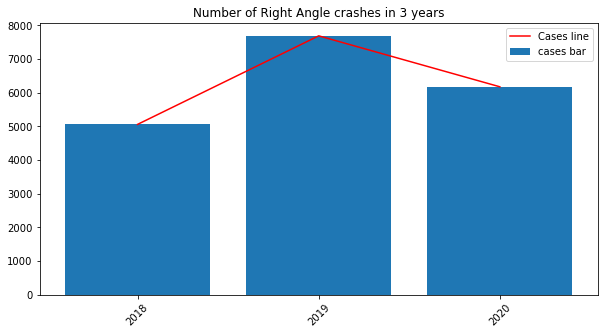

In [105]:
rows = spark\
    .sql(f"""
    select cast(year(accident_date) as string) yr, count(1) RightAngle_crash
    from v0
    where (description = 1 or description = 5) and (year(accident_date) between 2018 and 2020)
    group by yr
    order by yr
    """)\
        .collect()

pdf = pd.DataFrame(rows, columns=['yr','RightAngle_crash'])
plt.figure(figsize=(10,5))
plt.clf()
bar = plt.bar(pdf['yr'],pdf['RightAngle_crash'], label='cases bar')
#pdf.plot(x='yr',y='cases',kind='bar',figsize=[10,5],rot=45)
plt.plot(pdf['yr'],pdf['RightAngle_crash'],'r', label='Cases line')
plt.xticks(rotation=45)
plt.legend()
plt.title('Number of Right Angle crashes in 3 years')
plt.show()


In [262]:
rows = spark\
    .sql(f"""
    select count(1) as cases,
    CASE 
      WHEN description = 1 THEN 'Right Angle'
      WHEN description = 2 THEN 'Head on'
      WHEN description = 3 THEN 'Rear end' 
      WHEN description = 4 THEN 'Sidewipe'
      WHEN description = 5 THEN 'Right Angle'
      WHEN description = 6 THEN 'Struck fixed object'
      ELSE 'Other'
    END AS crashtype
    from v0
    where (year(accident_date) between 2018 and 2020)
    group by crashtype
    order by crashtype
    """)\
        .collect()


### Plot number of crashes by different type
Right angle crash is the second most crash type of all accidents behind READ END.

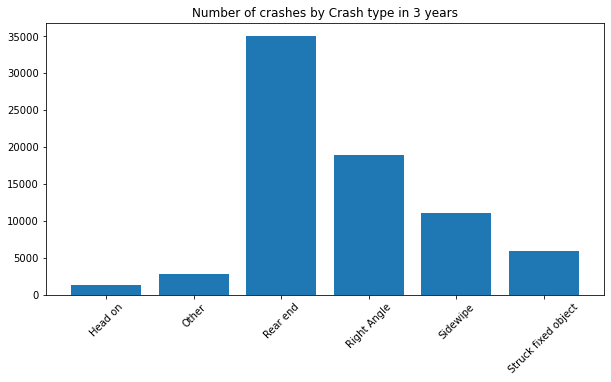

,cases,crashtype
0,1295,Head on
1,2757,Other
2,35058,Rear end
3,18918,Right Angle
4,11129,Sidewipe
5,5930,Struck fixed object


In [263]:
# def label (row):
#      if row['crash_type'] == 1 :
#         return 'Right Angle' 
#      elif row['crash_type'] == 2 :
#         return 'Head on' 
#      elif row['crash_type'] == 3 :
#         return 'Rear end' 
#      elif row['crash_type'] == 4 :
#         return 'Sidewipe' 
#      elif row['crash_type'] == 5 :
#         return 'Left Angle with Thru' 
#      elif row['crash_type'] == 6 :
#         return 'Struck fixed object'
#      else:
#         return 'Other' 

pdf = pd.DataFrame(rows, columns=['cases','crashtype'])
plt.figure(figsize=(10,5))
plt.clf()

#pdf['crashtype'] =pdf.apply(lambda row: label(row), axis=1)

bar = plt.bar(pdf['crashtype'],pdf['cases'], label='cases')
#pdf.plot(x='crash_type',y='cases',kind='bar',figsize=[10,5],rot=45)
#x = ['Right Angle','Head on','Rear end','Sidewipes','Left turn with thru','Struct fixed object','Other']
plt.xticks(x='crashtype',  rotation=45)
#plt.plot(pdf['crashtype'],pdf['cases'],'r', label='cases by type')
plt.title('Number of crashes by Crash type in 3 years')
plt.show()
pdf

### Plot number of sever right angle crahes in last three years.
Sever right angle crash-killed or serious injured is the most occured crash in the last three years.
Total close to 330 and almost one case every day. We must study and research!

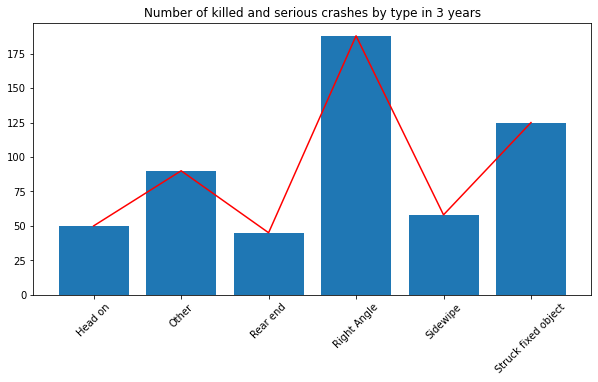

In [264]:
#Killed and serious crashes by type in last 3 years. We can see right angle (1)+leftThru (5) are really the main 
#types of serious crashes.
rows = spark\
    .sql(f"""
    select count(1) as cases,
    CASE 
      WHEN description = 1 THEN 'Right Angle'
      WHEN description = 2 THEN 'Head on'
      WHEN description = 3 THEN 'Rear end' 
      WHEN description = 4 THEN 'Sidewipe'
      WHEN description = 5 THEN 'Right Angle'
      WHEN description = 6 THEN 'Struck fixed object'
      ELSE 'Other'
    END AS crashtype
    from v0
    where ((description<8) and (severity=1 or severity=2)) and \
          (icu='U') and (year(accident_date) between 2018 and 2020)
    group by crashtype
    order by crashtype
    """)\
        .collect()
pdf = pd.DataFrame(rows, columns=['cases','crashtype'])
plt.figure(figsize=(10,5))
plt.clf()
#pdf['crashtype'] =pdf.apply(lambda row: label(row), axis=1)
bar = plt.bar(pdf['crashtype'],pdf['cases'], label='cases')
#pdf.plot(x='crash_type',y='cases',kind='bar',figsize=[10,5],rot=45)
#x = ['Right Angle','Head on','Rear end','Sidewipes','Left turn with thru','Struct fixed object','Other']
plt.xticks(x='crashtype',  rotation=45)
plt.plot(pdf['crashtype'],pdf['cases'],'r', label='cases by type')
#typex = ['Right Angle','Head on','Rear end','Sidewipes','Left turn with thru','Struct fixed object','Other']
#plt.xticks(x='crash_type', typex)
plt.title('Number of killed and serious crashes by type in 3 years')
plt.show()

<Figure size 432x288 with 0 Axes>

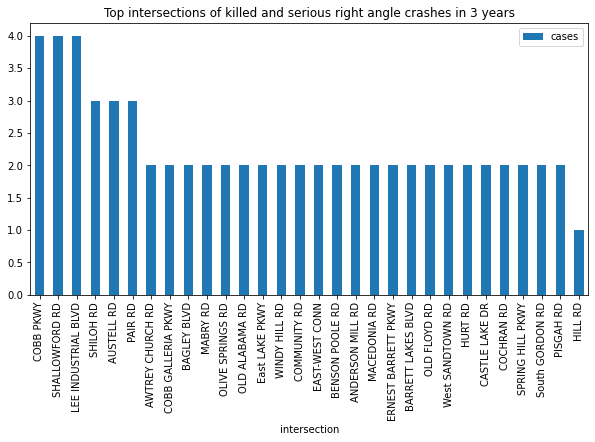

In [12]:
rows = spark\
    .sql(f"""
    select intersection intersection, count(1) cases
    from v0
    where ((intersection IS NOT NULL) and (severity=1 or severity=2) \
          and (description = 1 or description = 5)) \
    and (icu ='U') and (year(accident_date) between 2018 and 2020)
    group by intersection
    order by cases DESC
    limit 30
    """)\
        .collect()
pdf = pd.DataFrame(rows, columns=['intersection','cases'])
plt.clf()
pdf.plot(x='intersection',y='cases',kind='bar',figsize=[10,5],rot=90)
#plt.plot(pdf['crash_type'],pdf['cases'],'r', label='cases by type')
plt.title('Top intersections of killed and serious right angle crashes in 3 years')
plt.show()

<Figure size 432x288 with 0 Axes>

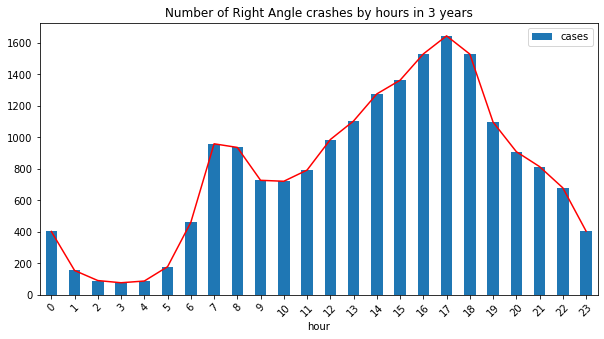

In [81]:
rows = spark\
    .sql(f"""
    select hour(accident_date)  hour, count(1) cases
    from v0
    where (description = 1 or description = 5) and (year(accident_date) between 2018 and 2020)
    group by hour(accident_date)
    order by hour
    """)\
        .collect()
pdf = pd.DataFrame(rows, columns=['hour','cases'])
plt.clf()
pdf.plot(x='hour',y='cases',kind='bar',figsize=[10,5],rot=45)
plt.plot(pdf['hour'],pdf['cases'],'r', label='cases by hours')
plt.title('Number of Right Angle crashes by hours in 3 years')
plt.show()

<Figure size 432x288 with 0 Axes>

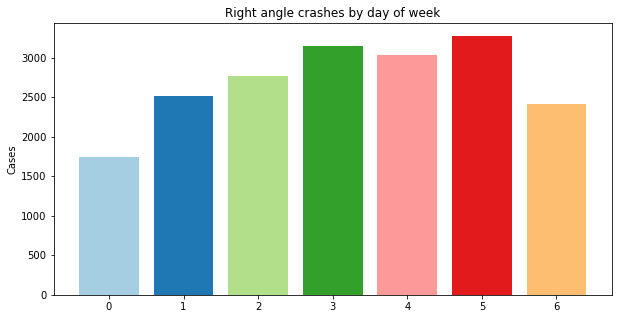

In [82]:
rows = spark\
    .sql(f"""
    select EXTRACT(dayofweek from accident_date)-1 as day_of_week, count(1) cases
    from v0
    where (description = 1 or description = 5) and (year(accident_date) between 2018 and 2020)
    group by EXTRACT(dayofweek from accident_date)
    order by day_of_week

    """)\
        .collect()

pdf = pd.DataFrame(rows, columns=['day_of_week','cases'])
plt.clf()
fig=plt.figure(figsize=(10,5))
#ax=fig.add_axes([0,0,10,5])
plt.bar(pdf["day_of_week"],pdf["cases"],color=plt.cm.Paired(pdf["day_of_week"]))
plt.ylabel('Cases')
#plt.legend()
plt.title("Right angle crashes by day of week")
#pdf.plot(x='day_of_week',y='cases',kind='bar', figsize=[10,5])
#ax=pdf.T.plot(kind='bar',label='day_of_week',colormap='Paired')
#ax.set_xlim(0.1,9.5)
#ax.set_xlabel('day of week')
plt.show()

<Figure size 432x288 with 0 Axes>

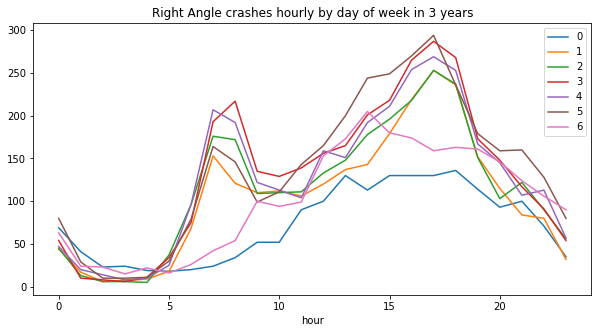

In [83]:
rows = spark\
    .sql(f"""
    select hour(accident_date)  hour, EXTRACT(dayofweek from accident_date) as day_of_week, count(1) cases
    from v0
    where (description = 1 or description = 5) and (year(accident_date) between 2018 and 2020)
    group by hour, day_of_week
    order by hour

    """)\
        .collect()

pdf = pd.DataFrame(rows, columns=['hour','day_of_week','cases'])
plt.clf()

_, ax = plt.subplots(figsize=(10,5))
for idx, gp in pdf.groupby('day_of_week'):
    idx=idx-1
    gp.plot(x='hour', y='cases', ax=ax, label=idx)
plt.title('Right Angle crashes hourly by day of week in 3 years')
plt.show()

### Let's visualize aggregate right angle crashes  in 3D in last 3 years to see the critical intersections
![](media/3dRightangle.PNG)

<a href="https://cobbcountyga.maps.arcgis.com/home/webscene/viewer.html?webscene=86ea3667070f4e8cbb9673287e240492"><b>Launnch the aggregate 3 year right angle crash 3D map</b></a>

###  Automate FHWA Network Screening Steps - prioritized crash sites on the BETA distribution probability

The following analyses are based on FHWA Network Screening steps (Source: HSM Part B, pp. 4-52 to 4-57)
Crash sites are prioritized based on the probability that the true proportion, pi, of a particular crash type
or severity is greater than the threshold proportion for each crash type, showing whether the location is performing worse than expected. This performance measure is not affected by regression-to-the-mean bias, and the only data needed to apply this method is crash type and location data., pi*. A threshold proportion (pi*) is selected for each population, typically based on the proportion of the target crash type or severity in the reference population. The steps are automated with Python scripts for easy calculation for any intersection and crash locations.

### Prepare data to get sever right angle and total population right angle crashes close to intersections
This might not be the perfect solution but can be really helpful to any agency with this automated process

In [150]:
#select top 10 intersection based on 3D and the most of serious right angle crash locations
objectid=" or OBJECTID = ".join(["7663","22111","22355","13078","29621","13330","22671","15613","6281","20813"])
oid = arcpy.AddFieldDelimiters(intersection, arcpy.Describe(intersection).OIDFieldName)
expression = "{0}=".format(oid)+objectid

In [149]:
#Write these top intersection locations to a feature class.
intersectSel=arcpy.SelectLayerByAttribute_management(intersection, "NEW_SELECTION", expression)
_=arcpy.management.CopyFeatures(intersectSel, 'intersectSel')

In [151]:
#Make buffer feature class from these 10 intersections to include crash locations within the distance of the intersection.
_=arcpy.analysis.Buffer("intersectSel", "intersectBuffer", "1500 Feet")

In [156]:
#Select all Killed and serious right angle crash in the last 3 years.This will be our target crashes.
sql_where="ACCIDENTDATE BETWEEN timestamp '2018-03-01 00:00:00' And timestamp '2021-04-01 00:00:00' AND \
          ((DESCRIPTION = 1 Or DESCRIPTION = 5) AND (SEVERITY=1 OR SEVERITY =2))"
KilledSerious3yr=arcpy.SelectLayerByAttribute_management(prjCrash, "NEW_SELECTION", sql_where)
# Write the selected sever right angle crashes to a new feature class
_=arcpy.management.CopyFeatures(KilledSerious3yr, 'rightAngleSevere_3yr')

In [157]:
#Do intersection buffer feature spatial join with right angle crash in last three years this will give us a join_count of severe crashes 
#in that intersection buffer. The join_count will be the right angle target crashes in the intersections
_=arcpy.analysis.SpatialJoin('intersectBuffer','rightAngleSevere_3yr','intersect_join',join_type='KEEP_ALL',
                             match_option='intersects')

In [158]:
#get all right angle crashes from the 10 buffer intersections in the last three years. The will be our referenced population
#layer. Write this selected features to a new feature class.
right_where="ACCIDENTDATE BETWEEN timestamp '2018-03-01 00:00:00' And timestamp '2021-04-01 00:00:00' AND \
          ((DESCRIPTION = 1 Or DESCRIPTION = 5))"
rightAngle3yr=arcpy.SelectLayerByAttribute_management(prjCrash, "NEW_SELECTION", right_where)
_=arcpy.management.CopyFeatures(rightAngle3yr, 'rightAngle_3yr')

In [159]:
#spatial join with right angle crash in last three years this will give us a join_count_1 of crashes 
#in that intersection buffer which is total number of right angle crashes.
_=arcpy.analysis.SpatialJoin('intersect_join','rightAngle_3yr','intersect_join2',join_type='KEEP_ALL',
                             match_option='intersects')

### FHWA network screening involves the following six major steps. <a href="https://safety.fhwa.dot.gov/systemic/fhwasa17008/">reference</a>

<i>Step 1 – Calculate Observed Proportions:</i> Calculate the observed proportion of the target crash
type or crash severity for each site that has experienced two or more crashes of the target crash
type or crash severity using the following equation.

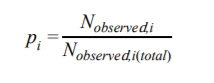
where,
![](media/step2.PNG)
<i>Step 2 – Estimate a Threshold Proportion:</i> Select the threshold proportion of crashes, p*
i, for a specific crash type. The proportion of a specific crash type in the entire population is calculated
using the following equation.

![](media/step3.PNG)
where,
![](media/step2desc.PNG)
<i>Step 3 – Calculate Sample Variance (s2):</i> Calculate the sample variance for each subcategory using
the following equation
![](media/step4.PNG)
for Nobserved,i(total) ≥ 2
where,
![](media/step5.PNG)

<i>Step 4 – Calculate Alpha and Beta Parameters:</i> Calculate the sample mean proportion of target
crashes by crash type or crash severity for all sites under consideration using the following
equation.
![](media/step6.PNG)
where nsites is the total number of sites in the subcategory, and 𝑝𝑖∗
is the mean proportion of target
crashes by crash type or crash severity. Next, calculate alpha (α) and beta (β) for each subcategory
using the following equations
![](media/step7.PNG)
where s2
is variance and 𝑝𝑖∗is mean proportion of target crash types.

<i>Step 5 – Calculate the Probability:</i> Calculate the probability using the following equation. 
![](media/step8.PNG)
where,
![](media/step9.PNG)

<i>Step 6 – Rank Locations:</i> Rank sites based on the probability of target crashes occurring at the site.

<B>Add required fields for FHWA Screening calculation for safety threshold probability Beta Distribution
source from above.</b>

In [160]:
fhwaflds=[['sumJoin','long'],['sumJoin1','long'],['observed','double'],['threshold','double'],
          ['variance','double'],['a','double'],['b','double'],['BETADIST','double'],['rank','long']]
_=arcpy.management.AddFields('intersect_join2',fhwaflds)

<b>Update the sum of each intersection of severe right angle crashes and total right angle crashes.Update the threshold proprortion and paramters of alhpa and beta. Calculate final BETA Distribution and rank the intersection based on the equations and steps abbove</b>

In [308]:
desc = arcpy.Describe('intersect_join2')
flds = [fld.name for fld in desc.fields]
sumJoin=0
sumJoin1=0
observedTotal=0.0
variance=0.0
obs=0.0
betaDist=[]
inter=[]
c = arcpy.GetCount_management('intersect_join2')[0]
c=float(c)
with arcpy.da.UpdateCursor('intersect_join2', ['Join_Count','Join_Count_1','observed']) as cursor:
    idx = cursor.fields.index("Join_Count")
    idx1 = cursor.fields.index("Join_Count_1")
    idx3 = cursor.fields.index("observed")
    for row in cursor:
        sumJoin += row[idx] #sumJoin + row.Join_Count
        sumJoin1 +=row[idx1] #sumJoin1+ row.Join_Count1
        variance+=(row[idx]**2-row[idx])/(row[idx1]**2-row[idx1])
        obs= (row[idx])/(row[idx1])
        row[idx3]=obs
        observedTotal+=row[idx]/row[idx1]
        cursor.updateRow(row)

with arcpy.da.UpdateCursor('intersect_join2', ['sumJoin','sumJoin1','threshold','NAME_1','NAME_2','variance','a','b','BETADIST','Join_Count','Join_Count_1']) as cursor:
    idx = cursor.fields.index("sumJoin")
    idx1 = cursor.fields.index("sumJoin1")
    idx2 = cursor.fields.index("threshold")
    idx3 = cursor.fields.index("NAME_1")
    idx4 = cursor.fields.index("variance")
    idx5 = cursor.fields.index("a")
    idx6 = cursor.fields.index("b")
    idx7= cursor.fields.index("BETADIST")
    idx8=cursor.fields.index("Join_Count")
    idx9=cursor.fields.index("Join_Count_1")
    idx10=cursor.fields.index("NAME_2")
    
    thresholdPro=sumJoin/sumJoin1
    varr=(1.0/(c-1.0))*(variance-((1.0/c)*(observedTotal**2)))
    a=(thresholdPro**2-thresholdPro**3-varr*thresholdPro)/varr
    b=a/thresholdPro-a
    
    for row in cursor:     
        row[idx]=sumJoin
        row[idx1]=sumJoin1
        row[idx2]=thresholdPro
        row[idx4]=varr
        row[idx5]=a
        row[idx6]=b
        row[idx7]=1-stats.beta.cdf(thresholdPro, a+row[idx8], b+row[idx9]-row[idx8])
        inter.append(row[idx3]+"@"+row[idx10])
        betaDist.append(1-stats.beta.cdf(thresholdPro, a+row[idx8], b+row[idx9]-row[idx8]))
        cursor.updateRow(row)
        
#_=arcpy.management.CalculateField('intersect_join2','sumJoin','sum([!Join_Count!])')

<b>Plot the BETA Distribution bar chart. High percentage means rank is higher exceeding the threshold</b>

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

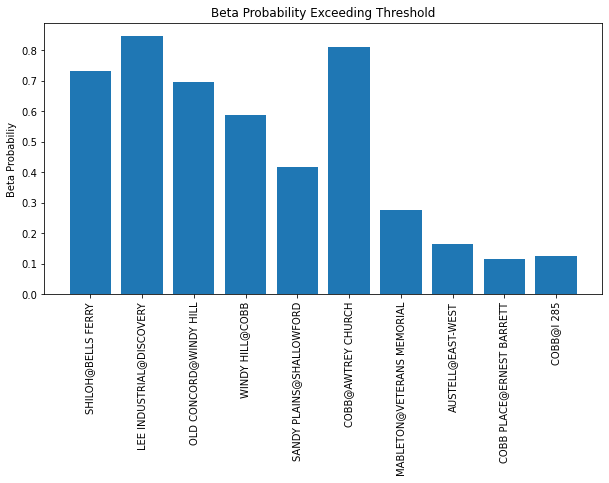

In [318]:
plt.figure(figsize=(10,5))
plt.clf()
x = inter
#plt.plot(x, betaDist, color='blue', lw=2, ls='-', alpha=0.5, label='Beta Probability for top intersections')
plt.bar(inter,betaDist)
plt.ylabel("Beta Probabiliy")
#pdf.plot(x=inter,y=betaDist,kind='bar',figsize=[10,5],rot=90)
plt.title('Beta Probability Exceeding Threshold')
plt.xticks(rotation = 90)

In [363]:
# Sort and add RANK value of intersection into the feature class
rec=0
def autoIncrement():
    global rec
    pStart    = 1 
    pInterval = 1 
    if (rec == 0): 
        rec = pStart 
    else: 
        rec += pInterval 
    return rec
rows = arcpy.UpdateCursor('intersect_join2', "", "", "", "BETADIST" + " D")
for row in rows:
    row.setValue("rank", autoIncrement())
    rows.updateRow(row)

In [362]:
b, a = (list(x) for x in zip(*sorted(zip(betaDist,inter), reverse=True)))
print (f"Rank ","Probablility"," "*7,"Intersection" )
for i in range(len(b)):    
# printing result
     print(i+1, " "*3, '{:.5%}'.format(b[i])," "*5,a[i])

Rank  Probablility         Intersection
1     84.74718%       LEE INDUSTRIAL@DISCOVERY
2     80.86137%       COBB@AWTREY CHURCH
3     73.09192%       SHILOH@BELLS FERRY
4     69.46106%       OLD CONCORD@WINDY HILL
5     58.71537%       WINDY HILL@COBB
6     41.86361%       SANDY PLAINS@SHALLOWFORD
7     27.59737%       MABLETON@VETERANS MEMORIAL
8     16.64281%       AUSTELL@EAST-WEST
9     12.51901%       COBB@I 285
10     11.44460%       COBB PLACE@ERNEST BARRETT


### Create a BETA Distribution map to rank the intersection with sever right angle crashes
Intersection circle symbols are proportional to the rank

![](media/beta.PNG)

[Launnch the BETA Distribution Rank Map](https://cobbcountyga.maps.arcgis.com/apps/View/index.html?appid=cc2255473386495cb28360eb228c4ced)

In [ ]:
#add count1 as crash field for joined sum purpose
countfld=[['count1','short']]
_=arcpy.management.AddFields('crash_rightangleleft_3yr',countfld)
_=arcpy.management.CalculateField('crash_rightangleleft_3yr','count1',1)

# Create a new fieldmappings and add the two input feature classes.
fieldmappings = arcpy.FieldMappings()
fieldmappings.addTable('CobbRoads_AADT_flow')
fieldmappings.addTable('crash_rightangleleft_3yr')

count1FieldIndex = fieldmappings.findFieldMapIndex("count1")
fieldmap = fieldmappings.getFieldMap(count1FieldIndex)
 
# Get the output field's properties as a field object
field = fieldmap.outputField
 
# Rename the field and pass the updated field object back into the field map
field.name = "sum_count"
field.aliasName = "sum_count"
fieldmap.outputField = field
 
# Set the merge rule to sum and then replace the old fieldmap in the mappings object
# with the updated one
fieldmap.mergeRule = "Sum"
fieldmappings.replaceFieldMap(count1FieldIndex, fieldmap)
#spatial join Cobb Roads with AADT
_=arcpy.analysis.SpatialJoin('CobbRoads_AADT_flow','crash_rightangleleft_3yr','roads_joined_rightangle',
                              "#", "#", fieldmappings)

In [3]:
# select only Cobb County and create new feature class
rightangleAADT=arcpy.SelectLayerByAttribute_management('roads_joined_rightangle', 'NEW_SELECTION', 
                                        "Join_Count > 0")
# Write the selected features to a new feature class
_=arcpy.management.CopyFeatures(rightangleAADT, 'rightAngleAADT')

In [4]:
#add crash rate field 
ratefld=[['rate','double']]
_=arcpy.management.AddFields('roads_joined_rightangle',ratefld)

### Calculate crash rate for cobb roads based on FHWA Roadway Departure Safety
The crash rate for roadway departure crashes on a roadway is calculated as:
The variables in this equation are:
![](media/Rateformula.gif)
R = Roadway Departure crash rate for the road segment expressed as crashes per 100 million vehicle-miles of travel,
C = Total number of roadway departure crashes in the study period
V = Traffic volumes using Average Annual Daily Traffic (AADT) volumes
N = Number of years of data
L = Length of the roadway segment in miles
This equation relies on having traffic volume information To determine how to obtain actual and estimated traffic volumes for a particular roadway, a local agency can contact its State highway agency, LTAP representative, or other state agencies.
A "crashes per mile" rate for road segments is calculated as:
![](media/rateformula2.gif)
Where:

R = Crashes per mile for the road segment expressed as crashes per each 1 mile of roadway per year.
C = Total number of crashes in the study period.
N = Number of years of data.
L = Length of the roadway segment in miles.


In [5]:
# Calculate crash rate function
cal_crashrate=\
"""
def cal_crashrate(c, length):
   try:
      return c*5280.0/(3*length)
   except:
      return 0.0
"""
_=arcpy.management.CalculateField('roads_joined_rightangle', 'rate', 'cal_crashrate(!Join_Count!,!LENGTH!)', 
                                  code_block=cal_crashrate)

### Right angle crash rate map in last three years
![](media/crashrate.PNG)

[Launnch the BETA Distribution Rank Map and turn on the crash rate layer](https://cobbcountyga.maps.arcgis.com/apps/View/index.html?appid=b1f4fd0f898147b0a62f450e4bf06ec0)

In [107]:
spark_stop()